# Problem formulation

We want to classify between Harry Potter and Star Wars theme songs based on humming and whistles made by people to these songs. Since the data is crowd sourced, it has people singing in different pitches and tune, which is out of sync with the actual music. Also, the data was collected from a diverse group of students with different nationality, ethnicity, gender, and age. Given that the data is crowd sourced, it can also have noise, leading to quality issues between data points. These challenges make it an interesting problem to solve.

# Machine Learning pipeline
The input data consists of the audio file and meta data encoded in the file name of audio files.
The ML pipeline involves three stages. 
- Data Preprocessing - Meta data from file names needs to be extracted. Output of this stage will be dataframes with each file name and song name columns.
- Feature Engineering - Features should be extracted from the audio files which are in WAV format. These can be audio/signal processing features such as pitch, frequencies, power, etc. Noise needs to be removed before feature extraction and  then the extracted features will be noramalized.
- Classification - Models can be trained based on the extracted features and song name collected earlier. The classifier will predict the song label from features extracted from unseen audio data. 

# Transformation stage

There are two stages in transformations.
- Meta data extraction - Audio files are written in `[participant_number]_[audio type]_[audio number]_[song label]` format. Audio type can be `hum` or `whistle`. Audio number can be 1, 2, 3 or 4. Song label can be `Potter` or `StarWars`. All the audio files from part 1 and part 2 for Star Wars and Harry Potter were downloaded and merged into two folders `Potter` or `StarWars`. Meta data will be extracted from the audio file names and the folder names and will be stored as a dataframe. This will include `file_name` and `song name`.
- Feature extraction - Features from WAV file are extracted in this stage. Noice is removed from audio file before feature extraction using the [noisereduce](https://github.com/timsainb/noisereduce) package. They are digital signal processing features such as `power`, `mean pitch`, `std of pitch`, `natural frequency`, `tempo`, `zero crossings`, etc. Dask was used to perform this task in parellal since sequential execution was taking more than 5 mins for 100 records while trying to extract many features. Dask brought down feature extraction time for whole data set to below 10 mins. 

In [1]:
import glob
import numpy as np
import pandas as pd

import librosa
import noisereduce as nr

from dask.distributed import Client
from dask import delayed

# Initialize the Dask client with 4 workers
client = Client(n_workers=4)


In [2]:
def get_metadata():
    '''
    Read files and extract the metadata
    '''
    potter_files_path = 'Potter/*.wav'
    potter_files = glob.glob(potter_files_path)
    potter = pd.DataFrame(potter_files, columns=['file_name']).set_index('file_name')
    potter['song'] = 0
    starwars_files_path = 'StarWars/*.wav'
    starwars_files = glob.glob(starwars_files_path)
    starwars = pd.DataFrame(starwars_files, columns=['file_name']).set_index('file_name')
    starwars['song'] = 1
    df = pd.concat([potter, starwars])
    return df


def getPitch(x, fs, winLen=0.02):
  '''
  Extract the pitch from the audio file. 
  '''
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                               frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag


def extract_features(file_name, fs=None, scale_audio=False, onlySingleDigit=False):
    '''
    Get the features from a single audio file
    '''
    x, fs = librosa.load(file_name, sr=fs)
    x = nr.reduce_noise(y=x, sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x, fs, winLen=0.02)
      
    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)
    zero_crossings = librosa.feature.zero_crossing_rate(x).sum()
    tempo = librosa.beat.tempo(x, sr=fs)[0]
    return [power, pitch_mean, pitch_std, voiced_fr, zero_crossings, tempo]


def get_features(labels_file):
    '''
    Generate features for given dataset
    '''
    X = []
    for file in labels_file.index:
        x = delayed(extract_features)(file, fs=44100, scale_audio=True, onlySingleDigit=True)
        X.append(x)
    X_delayed = delayed(np.array)(X)
    return X_delayed.compute()

# Modelling

Multiple classifier models are evaluated. They will be evaluated based on the cross validation accuracy and test data accuracy
- Logistic Regression
- Naive Bayes model
- Support Vector Classifier
- K Nearest Neighbour
- Decision Tree
- Random Forest Ensemble model

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

algorithms = {
  'logistic': LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000),
  'NB': GaussianNB(),
  'SVM': svm.SVC(C=1, gamma=2),
  'KNN': KNeighborsClassifier(n_neighbors=3),
  'DecisionTree': DecisionTreeClassifier(),
  'RandomForest': RandomForestClassifier()
}

def get_pipeline(algorithm):
  '''
  Returns a pipeline for the algorithm.
  '''
  model = algorithms[algorithm]
  return make_pipeline(StandardScaler(), model)

# Methodology
Train and Test data will be created using a random split with 80:20 ratio. Multiple models will be trained and validated with K-fold cross validation and finally tested against the test data. Models will be evaludated using cross validation accuracy since the data is balanced. Aparat from accuracy Precision, Recall and F1-score will also be analysed. A model with high accuracy on test data will be considered the best model since that model is generalising better.

# Dataset

The data set consist of 6 features **power, pitch_mean, pitch_std, frequency, tempo, zero_crossings** and an output variable **song**, which is enocded as 0 and 1 indicating Potter and StarWars respectively. They were obtained after preprocessing and extracting features from the raw audio files. Each of those stages are explained in the Transformations section above. 

The data was split into training and testing set with a random 80:20 split.

In [4]:
metadata = get_metadata()
print(f'Length of data: {len(metadata)}')
print(metadata.head())
print('\ncount of each song:')
print(metadata.song.value_counts())

Length of data: 824
                              song
file_name                         
Potter/S54_hum_2_Potter.wav      0
Potter/S135_hum_2_Potter.wav     0
Potter/S36_hum_1_Potter.wav      0
Potter/S157_hum_1_Potter.wav     0
Potter/S169_hum_1_Potter.wav     0

count of each song:
1    413
0    411
Name: song, dtype: int64


In [5]:

X = get_features(labels_file=metadata)
y = metadata['song'].values
print('\nThe shape of X is', X.shape)
print('\nThe shape of y is', y.shape)

100%|██████████| 2/2 [00:00<00:00,  2.21it/s]

100%|██████████| 2/2 [00:00<00:00,  2.34it/s]

100%|██████████| 2/2 [00:00<00:00,  2.26it/s]

100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

100%|██████████| 2/2 [00:00<00:00,  2.95it/s]

100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

100%|██████████| 2/2 [00:00<00:00,  5.28it/s]

100%|██████████| 2/2 [00:02<00:00,  1.10s/it]

100%|██████████| 2/2 [00:00<00:00,  4.39it/s]

100%|██████████| 2/2 [00:00<00:00,  4.29it/s]

100%|██████████| 2/2 [00:00<00:00,  4.52it/s]

100%|██████████| 2/2 [00:00<00:00,  4.47it/s]

100%|██████████| 2/2 [00:02<00:00,  1.03s/it]

100%|██████████| 2/2 [00:00<00:00,  4.28it/s]

100%|██████████| 2/2 [00:00<00:00,  3.86it/s]

100%|██████████| 2/2 [00:00<00:00,  3.96it/s]

100%|██████████| 2/2 [00:02<00:00,  1.44s/it]

100%|██████████| 2/2 [00:02<00:00,  1.31s/it]

100%|██████████| 2/2 [00:02<00:00,  1.03s/it]

100%|████████


The shape of X is (824, 6)

The shape of y is (824,)


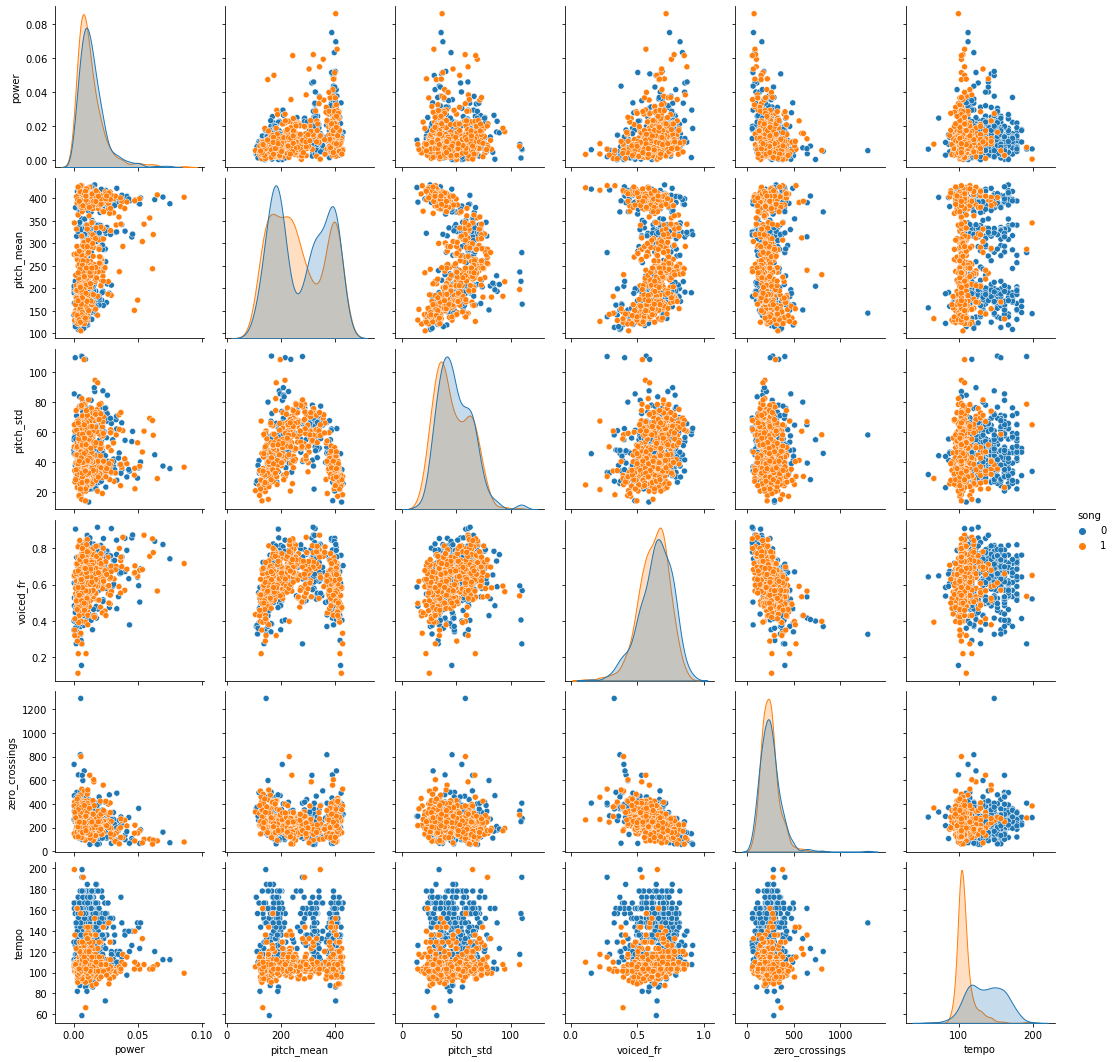

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

columns = ['power', 'pitch_mean', 'pitch_std', 'voiced_fr', 'zero_crossings', 'tempo']
df = pd.DataFrame(X, columns=columns)
df['song'] = y
sns.pairplot(df, hue='song')

In [7]:
# select only the features that are useful for classification
req_cols = [columns.index(x) for x in ('pitch_mean', 'pitch_std', 'tempo')]
X_req = X[:, req_cols]


# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_req, y, test_size=0.2, random_state=10)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((659, 3), (165, 3), (659,), (165,))

# Results

Multiple models were evaluated for different set of features. I used [MLFlow](https://mlflow.org/) to track the experiments since I was trying out multiple experiments.

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from mlflow import start_run, log_param, log_params, log_metric


for algorithm in ('logistic', 'SVM', 'KNN', 'DecisionTree', 'NB', 'RandomForest'):
  with start_run(run_name=algorithm) as run:
    print('Model:', algorithm)
    log_param('noise_reduction', True)
    log_param('Training samples', X_train.shape)
    pipeline = get_pipeline(algorithm)
    log_params(pipeline.get_params())
    scores = cross_val_score(pipeline, X_train, y_train, cv=5)
    print('%0.2f accuracy with a standard deviation of %0.2f' % (scores.mean(), scores.std()))
    log_metric('CV accuracy', scores.mean())
    log_metric('CV accuracy std', scores.std())
    model = pipeline.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    print('Test accuracy %0.2f' % score)
    log_metric('Test accuracy', score)
    predicted = model.predict(X_test)
    print(classification_report(y_test, predicted))
    prf = precision_recall_fscore_support(y_test, predicted, average='weighted')
    log_metric('Precision', prf[0])
    log_metric('Recall', prf[1])
    log_metric('F1', prf[2])
    print(prf)
    print('-'*100)

Model: logistic
0.80 accuracy with a standard deviation of 0.02
Test accuracy 0.78
              precision    recall  f1-score   support

           0       0.89      0.65      0.75        85
           1       0.71      0.91      0.80        80

    accuracy                           0.78       165
   macro avg       0.80      0.78      0.77       165
weighted avg       0.80      0.78      0.77       165

(0.8006197268646376, 0.7757575757575758, 0.7723065381145007, None)
----------------------------------------------------------------------------------------------------
Model: SVM
0.83 accuracy with a standard deviation of 0.02
Test accuracy 0.80
              precision    recall  f1-score   support

           0       0.84      0.75      0.80        85
           1       0.76      0.85      0.80        80

    accuracy                           0.80       165
   macro avg       0.80      0.80      0.80       165
weighted avg       0.80      0.80      0.80       165

(0.80425783560023

In [9]:
# Normalise the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
from sklearn.model_selection import GridSearchCV
rfc = RandomForestClassifier()
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
grid = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
grid.fit(X_train_scaled, y_train)
grid.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 500}

In [11]:
rf = RandomForestClassifier(criterion='gini', max_depth=6, max_features='log2', n_estimators= 500)
scores = cross_val_score(rf, X_train_scaled, y_train, cv=5)
print('%0.2f accuracy with a standard deviation of %0.2f' % (scores.mean(), scores.std()))
rf.fit(X_train_scaled, y_train)
rf.score(X_test_scaled, y_test)

0.83 accuracy with a standard deviation of 0.03


0.7818181818181819

**Observations**
- SVM is performing very well with minimal features.
- Random forest is performing slightly better than SVM with more features. However, Random Forest takes more time to train.
- Main features distinguishing between Potter and Starwars are tempo and mean pitch. SVM is performing really well with just these 2 features.

Experiments summary from MLFlow dashboard is attached below.

![Summary of experiments](Experiment-Summary.png "Experiment Summary")

In [12]:
## Saving the model
import joblib

pipeline = make_pipeline(StandardScaler(), svm.SVC(C=1, gamma=2, probability=True))
pipeline.fit(X_train, y_train)
score = pipeline.score(X_test, y_test)
print('Test accuracy %0.2f' % score)
joblib.dump(pipeline, 'model.pkl')

Test accuracy 0.80


['model.pkl']

# Conclusions

- Tempo and Pitch are the most important features to distinguish between Harry Potter and Star Wars
- SVM is performing really well with minimal features for classifications.
- Ensemble models outperform standalone models like SVM with enough features.
- Both Random Forest and SVM models are giving decent accuracy on test data (~80%). However, this could be improved by exploring better feature extraction, boosting algorithms, and advanced algorithms like Neural Nets.
- Feature extraction was the key to improve accuracy of model. I have tried various features that librosa supports such as zero crossing rate, mfcc, spectral_centroid, beat_track, etc. However, they weren't much helpful.

**Possible Improvements**
- Other ensemble models like Light GBM and XGBOOST might improve the accuracy. This is an improvement that can be considered.
- Reducing noise in audio improved the accuracy. Other methods for noise reduction can be evaluated to improve classifier.
- Noise trimming can be applied to remove the begining and end of audio with empty voice.
- Explore the accuracy by training only on Hummings from the dataset.
- Other features can also be explored to improve accuracy.